In [32]:
import cheetah
from typing import Dict, Optional
import torch
import torch.nn as nn
from xopt import Xopt, VOCS, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.prior_mean import CustomMean
import matplotlib.pyplot as plt

In [2]:
def simple_fodo_problem(
    input_param: Dict[str, float], incoming_beam: Optional[cheetah.Beam] = None
) -> Dict[str, float]:
    if incoming_beam is None:
        incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-4),
            sigma_y=torch.tensor(2e-3),
            sigma_xp=torch.tensor(1e-4),
            sigma_yp=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
        )

    fodo_segment = cheetah.Segment(
        [
            cheetah.Quadrupole(
                length=0.1, k1=torch.tensor(input_param["q1"]), name="Q1"
            ),
            cheetah.Drift(length=0.5, name="D1"),
            cheetah.Quadrupole(
                length=0.1, k1=torch.tensor(input_param["q2"]), name="Q2"
            ),
            cheetah.Drift(length=0.5, name="D1"),
        ]
    )

    out_beam = fodo_segment(incoming_beam)

    beam_size_mse = torch.mean(out_beam.sigma_x**2 + out_beam.sigma_y**2)
    beam_size_mae = torch.mean(out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
    return {
        "mse": beam_size_mse.detach().numpy(),
        # "bilog_mse": (beam_size_mse.sign() * (beam_size_mse.abs() + 1).log()).detach().numpy(),
        "log_mse": beam_size_mse.log().detach().numpy(),
        "mae": beam_size_mae.detach().numpy(),
        "log_mae": beam_size_mae.log().detach().numpy(),
    }

In [23]:
vocs_config = """ 
variables:
    q1: [-30, 15]
    q2: [-15, 30]
objectives:
    mae: minimize
"""

vocs = VOCS.from_yaml(vocs_config)
generator = UpperConfidenceBoundGenerator(beta=1.0, vocs=vocs)
evaluator = Evaluator(
    function=simple_fodo_problem, function_kwargs={"incoming_beam": None}
)

In [24]:
xopt = Xopt(
    vocs=vocs,
    generator=generator,
    evaluator=evaluator,
)

In [25]:
xopt.evaluate_data(
    {
        "q1": 0,
        "q2": 0,
    }
)
for i in range(10):
    xopt.step()

In [26]:
xopt.data

,q1,q2,mse,log_mse,mae,log_mae,xopt_runtime,xopt_error
0,0.000000,0.000000,4.0388004e-06,-12.419563,0.0021598018,-6.1377387,0.003821,False
1,-30.000000,30.000000,4.925818e-05,-9.918435,0.007041119,-4.955988,0.000707,False
2,12.436117,-10.599817,8.4483845e-06,-11.681536,0.0030539266,-5.791327,0.000587,False
3,-6.948713,-11.483474,2.0395764e-07,-15.405354,0.00063868245,-7.356103,0.000647,False
4,-17.231483,-15.000000,3.6763697e-06,-12.513585,0.0023610082,-6.0486665,0.000759,False
5,-2.443615,-15.000000,9.0494964e-08,-16.217972,0.0003788989,-7.878241,0.000578,False
6,-5.413477,-15.000000,2.1901946e-07,-15.3341055,0.0006618212,-7.320515,0.000676,False
7,-1.261992,-11.143716,4.218849e-07,-14.678534,0.0008453424,-7.075769,0.000571,False
8,-2.419985,-15.000000,9.0723404e-08,-16.21545,0.00038077572,-7.8733,0.000635,False
9,-12.415054,-3.769279,9.3768926e-07,-13.879848,0.0012311767,-6.6997848,0.000617,False


In [27]:
xopt.generator.model.models[0].mean_module.constant

Parameter containing:
tensor(1.0755, dtype=torch.float64, requires_grad=True)

## Test Custom Prior Mean

In [28]:
from click import Option
from xopt.generators.bayesian.models.standard import StandardModelConstructor


class FodoPriorMean(nn.Module):
    def __init__(self, incoming_beam: Optional[cheetah.Beam] = None):
        super().__init__()
        if incoming_beam is None:
            incoming_beam = cheetah.ParameterBeam.from_parameters(
                sigma_x=torch.tensor(1e-4),
                sigma_y=torch.tensor(2e-3),
                sigma_xp=torch.tensor(1e-4),
                sigma_yp=torch.tensor(1e-4),
                energy=torch.tensor(100e6),
            )
        self.incoming_beam = incoming_beam
        self.segment = cheetah.Segment(
            [
                cheetah.Quadrupole(length=0.1, k1=torch.tensor(0.0), name="Q1"),
                cheetah.Drift(length=0.5, name="D1"),
                cheetah.Quadrupole(length=0.1, k1=torch.tensor(0.0), name="Q2"),
                cheetah.Drift(length=0.5, name="D1"),
            ]
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        input_shape = X.shape
        X = X.reshape(-1, 2)
        y_s = torch.zeros(X.shape[:-1])
        for i, input_values in enumerate(X):
            self.segment.elements[0].k1 = input_values[0].float()
            self.segment.elements[2].k1 = input_values[1].float()
            out_beam = self.segment(self.incoming_beam)
            beam_size_mae = torch.mean(out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
            y_s[i] = beam_size_mae
        return y_s.reshape(input_shape[:-1])

In [29]:
gp_constructor = StandardModelConstructor(
    mean_modules={"mae":FodoPriorMean()}
)
generator_prior_mean = UpperConfidenceBoundGenerator(
    beta=1.0, vocs=vocs, gp_constructor=gp_constructor
)

xopt_prior_mean = Xopt(
    vocs=vocs,
    generator=generator_prior_mean,
    evaluator=evaluator,
)

Verifying model name='standard' use_low_noise_prior=True covar_modules={} mean_modules={'mae': FodoPriorMean(
  (incoming_beam): ParameterBeam(mu_x=tensor(0.), mu_xp=tensor(0.), mu_y=tensor(0.), mu_yp=tensor(0.), sigma_x=tensor(1.0000e-04), sigma_xp=tensor(1.0000e-04), sigma_y=tensor(0.0020), sigma_yp=tensor(1.0000e-04), sigma_s=tensor(1.0000e-06), sigma_p=tensor(1.0000e-06), energy=tensor(100000000.)), total_charge=tensor(0.))
  (segment): Segment(elements=ModuleList(
    (0): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q1', device="'cpu'")
    (1): Drift(length=0.5, name='D1', device='cpu')
    (2): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q2', device="'cpu'")
    (3): Drift(length=0.5, name='D1', device='cpu')
  ), name='unnamed', device='cpu')
)} trainable_mean_keys=[]


In [30]:
xopt_prior_mean.evaluate_data(
    {
        "q1": 0,
        "q2": 0,
    }
)
for i in range(10):
    xopt_prior_mean.step()

In [31]:
xopt_prior_mean.data

,q1,q2,mse,log_mse,mae,log_mae,xopt_runtime,xopt_error
0,0.000000,0.000000,4.0388004e-06,-12.419563,0.0021598018,-6.1377387,0.002938,False
1,-24.172925,30.000000,2.2030128e-05,-10.7231,0.0047147,-5.35707,0.000553,False
2,-12.273421,24.048014,4.0960202e-08,-17.010664,0.00024239883,-8.324926,0.000551,False
3,-12.319299,24.433301,4.1240067e-08,-17.003855,0.00024104114,-8.330543,0.000587,False
4,-12.493894,26.506315,4.339823e-08,-16.952847,0.00023722948,-8.346482,0.000529,False
5,-12.410131,25.526919,4.2273083e-08,-16.979115,0.00023818406,-8.342466,0.000529,False
6,-12.496631,26.540351,4.344093e-08,-16.951864,0.00023723325,-8.346467,0.000539,False
7,-12.389827,25.265586,4.200308e-08,-16.985523,0.00023872397,-8.340202,0.000538,False
8,-12.302009,24.332433,4.1171255e-08,-17.005526,0.00024139504,-8.329076,0.000527,False
9,-12.547434,27.091526,4.4167535e-08,-16.935276,0.00023771072,-8.344456,0.000591,False


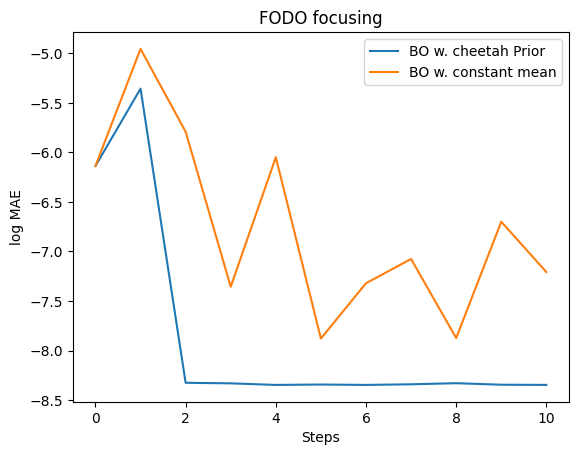

In [37]:
plt.plot(xopt_prior_mean.data["log_mae"], label='BO w. cheetah Prior')
plt.plot(xopt.data["log_mae"], label='BO w. constant mean')

plt.legend()
plt.xlabel("Steps")
plt.ylabel("log MAE")
plt.title("FODO focusing")
plt.savefig("fodo_example.png")